<a href="https://colab.research.google.com/github/Jahan08/LogBB-ML-Model-with-interpretation/blob/main/LogBB_Classification_ML_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the Required Libraries

In [ ]:
!pip install rdkit

In [ ]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator



In [ ]:
chembl_df = pd.read_csv("/content/All-LogBB-Categorical.csv")
chembl_df.head()

,Smiles,LogBB,Activity
0,CC1CCN(CC1)C(=O)c(c2)ccc3n(CC=C)c(c4c23)CCN(C4...,0,No
1,CC(=O)C,0,No
2,OCCCC,0,No
3,OCC,0,No
4,CO,0,No


In [ ]:
external_df = pd.read_csv("external data filepath")
external_df.head()

In [ ]:
compound_df = chembl_df.copy()

In [ ]:

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator

def smiles_to_fp(smiles, method="morgan10", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    # Handle cases where SMILES string is invalid
    if mol is None:
        print(f"Warning: Invalid SMILES string: {smiles}")
        return None  # or any default value you want to use for invalid SMILES

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan10":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=10, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

# Add column for fingerprint, handling potential None values
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

[18:12:57] WARNING: not removing hydrogen atom without neighbors
[18:12:57] WARNING: not removing hydrogen atom without neighbors
[18:12:57] WARNING: not removing hydrogen atom without neighbors
[18:12:57] WARNING: not removing hydrogen atom without neighbors
[18:12:58] WARNING: not removing hydrogen atom without neighbors
[18:12:58] WARNING: not removing hydrogen atom without neighbors
[18:12:58] WARNING: not removing hydrogen atom without neighbors


,Smiles,LogBB,Activity,fp
0,CC1CCN(CC1)C(=O)c(c2)ccc3n(CC=C)c(c4c23)CCN(C4...,0,No,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,CC(=O)C,0,No,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,OCCCC,0,No,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
external_compound_df = external_df.copy()

In [ ]:
# Add column for fingerprint
external_compound_df["fp"] = external_compound_df["Smiles"].apply(smiles_to_fp)
external_compound_df.head(3)
# NBVAL_CHECK_OUTPUT

In [ ]:
# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22

In [ ]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"/content/roc_auc", dpi=1200, bbox_inches="tight", transparent=True)
    return fig

###Helper function to calculate model performance.

In [ ]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [ ]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

###Preprocessing: Split the data

In [ ]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.LogBB.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=SEED)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 2722
Test data size: 681


###Random forest classifier

We start with a random forest classifier, where we first set the parameters.

We train the model on a random train-test split and plot the results.

In [ ]:
# Set model parameter for random forest
param = {
    "n_estimators": 150,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [ ]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.89
Specificity: 0.80
AUC: 0.90


####Save the model

In [ ]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "LogBB_RF_Classification_model.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model_RF, file)

###Load the model

In [ ]:
with open(model_pkl_file, 'rb') as file:
    model = pickle.load(file)

In [ ]:
external_x = external_compound_df.fp.tolist()

In [ ]:
external_RF_pred = model_RF.predict(external_x)

In [ ]:
external_RF_pred

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
# Print 5 first pIC50 predicted values
#first_5_prediction = [print(f"{value[0]:.2f}") for value in external_RF_pred.tolist()[0:5]]
external_RF_predicted = pd.DataFrame(external_RF_pred, columns=["predicted_Activity"])
predicted_RF_Activity_df = external_df.join(external_RF_predicted)
predicted_RF_Activity_df.head(3)

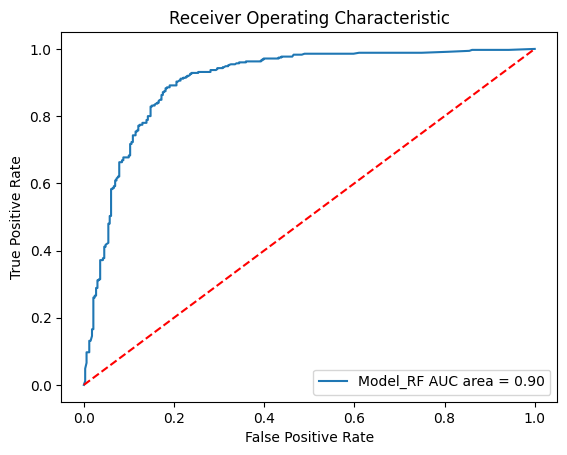

In [ ]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);